# Наивный баесовский классификатор

Решение задач классификации возможно без использование калссического машинного обучения. Для этого можно воспользоваться любым методом, который будет определять "похожесть" объектов друг на друга. 

Самым интересным методом по соотношению "простота/эффективность" является метод основанный на использовании формулы Баеса - "наивный баесовский классификатор". В его рамках нам необходимо определить значение метки класса при определённых условиях.

$$\hat{y} = \text{argmax}_y \> p(y | \mathbf{x})$$

Если (как показано выше) записать просто формулу поиска максимального значения условной вероятности, то окажется, что необходимо проводить большое число вычислений. При этом никак не используются априорные данные о соотношении "метка класса - признаки". 

Воспольземся формулой Баеса и перепишем классификатор

$$\hat{y} = \text{argmax}_y \> \frac{p( \mathbf{x} | y) p(y)}{p(\mathbf{x})}$$

Используя цепное правило можно разложить условную вероятность следующим образом:
$$p(x_1 |y) \cdot p(x_2 | x_1, y) \cdot ... \cdot p( x_d | x_1, ..., x_{d-1} y)$$
Однако, само по себе такое разложение не позволяет сократить число вычислений. Для сокращения числа выичлений делается "наивное" предположение: события на зависият друг от друга. То есть цепное правило схлобывается схлопывается к $\prod_i p(x_i | y)$. А общая формула определения исхода с учётом того, что $p(x)$ постоянна превращается в:
$$ \hat{y} = \text{argmax}_y \> = \prod_i p(x_i | y) p(y)$$

Таким образом все выичсления свелись к тому, чтобы узнать изначальные значения условных вероятностей для объектов каждого класса. 

Рассмотрим задачу классификации цифр на примере набора MINST. $p(y)$ легко оценить на основании известных заранее данных. То есть, если у нас в наборе $N$ данных при $m$ классах, то $p(y=m) = n_m/N$. 

Во вторых, необходимо рассмотреть самое изображение и определить значения $p(x_i | y)$. По существу - это вероятность того, что пиксель $x_i$ позволяет считать объект принадлижащим к классу $y$. Соответственно, необходимо будет просто для каждого пикселя расчитать соответствующую вероятность. Для того, чтобы избежать случая деления на 0, необходимо добавлять единицу к числу случаев при подсчёте. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
from torch import tensor
from torchvision import transforms, datasets

import tqdm

При создании счётчиков мы будем учитывать, изображения, которые "вытянем в строку". То есть каждое изображение будет иметь размер $784 * 1$. Для того, чтобы хранить вероятность отнесения каждого конкретного пикселя к какому-либо классу с учётом десятик классов потребуется тензор размером $784 * 10$. 

In [ ]:
# простое преобразование, переводит изображение в оттенки серого, в тензор и выполняет нормализацию
data_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize(mean=[0],std=[1])])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

# Инциазируем счётчики
xcount = torch.ones((784,10), dtype=torch.float32)
ycount = torch.ones((10), dtype=torch.float32)

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# считаем вероятности
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

Визуализируем "тепловые портреты" цифр и вероятности отнесения цифры к тому или иному классу. То есть на картинках представлены те самые проятности отнесения каждого пикселя к той или иной цифре.

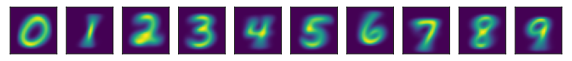

0.0987169 0.1123646 0.0993001 0.102183 0.0973671 0.0903516 0.0986336 0.1044159 0.0975171 0.0991501


In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    axes[i].imshow(xcount[:, i].reshape((28, 28)).numpy())
    axes[i].axes.get_xaxis().set_visible(False)
    axes[i].axes.get_yaxis().set_visible(False)

plt.show()
print(*py.numpy().round(7))

Попробуем выполнить простую операцию подсчёта вероятности каким-либо тестовым примером.

In [ ]:
# Возьмём первый объект для теста
data, label = mnist_test[150]
data = data.reshape((784,1))

# Посчитаем все условные вроятности
xprob = (px * data + (1-px) * (1-data))
# Выполним операцию произведения
xprob = xprob.prod(0) * py

print('Ненормализованная вероятность', xprob)
# Нормализуем
xprob = xprob / xprob.sum()
print('Нормализованная вероятность', xprob)

Ненормализованная вероятность tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Нормализованная вероятность tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


Мы получаем нулевой результат, связаный с тем, что операции умножения выполняются с очень маленькими числами, которые в результате зануляются из-за особенностей выполнения операций с плавающей точкой в python. 

Исправить ситуацию можно с помощью логарифмирования, которое переодит любое произведение под знаком логарифма в сумму логарифмов сомножителей. 

При этом для нормализации вероятности придётся реализовать собственный вариант softmax.

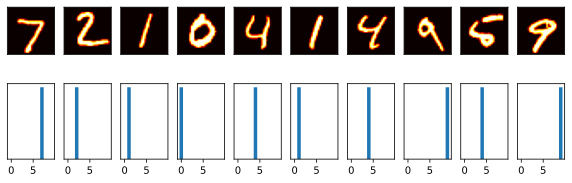

In [ ]:
# логарифмируем исходные вероятности
logpx = torch.log(px)
logpxneg = torch.log(1-px)
logpy = torch.log(py)

def bayespost(data):
    # сумму логаримов вероятностей
    logpost = logpy.clone()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    # Вычтем наибольшее значение для избежания переполнения, таким образом получим нормализованные значения
    logpost -= torch.max(logpost)
    # Рассчитаем вероятности, используя softmax. 
    post = torch.exp(logpost).numpy()
    post /= np.sum(post)
    return post

fig, axes = plt.subplots(2, 10, figsize=(10, 3))

# Построим любые 10 изображений
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    
    axes[1, ctr].bar(range(10), post)
    axes[1, ctr].axes.get_yaxis().set_visible(False)
    axes[0, ctr].imshow(x.reshape((28, 28)).numpy(), cmap='hot')
    axes[0, ctr].axes.get_xaxis().set_visible(False)
    axes[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1

    if ctr == 10:
        break

plt.show()

Рассчитаем общую ошибку. 

In [ ]:
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)

Naive Bayes has an error rate of 0.1553


Посмотрим на использование некоторых из стандартных моделей наивного Баеса из sklearn. Описания моделей доступны по ссылке здесь: https://scikit-learn.org/stable/modules/naive_bayes.html

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
x_train = mnist_train.data.reshape((-1, 784))
y_train = mnist_train.targets

In [ ]:
x_test = mnist_test.data.reshape((-1, 784))
y_test = mnist_test.targets

In [ ]:
model = GaussianNB()

model.fit(x_train, y_train)

GaussianNB()

In [ ]:
y_pred = model.predict(x_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.5558
F1 Score: 0.5945579672067938


In [ ]:
model2 = MultinomialNB()

model2.fit(x_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model2.predict(x_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.8365
F1 Score: 0.8357340542783067


In [ ]:
model3 = ComplementNB()

model3.fit(x_train, y_train)

ComplementNB()

In [ ]:
y_pred = model3.predict(x_test)

accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.7285
F1 Score: 0.7396562386899508


Реализованная нами модель работает лучше представленных, хотя в целом по качеству сопоставима с MultinomialNB.